### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL - Exercise Sheet #06

#### Name:

In [1]:
import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Load the data set

In [2]:
fname= 'eyes_closed_VPal.npz'
cnt, fs, clab, mnt = bci.load_data(fname)

## Exercise 1: Artifact Correction with PCA  (4 points)
Using the backward model, estimate the source activity corresponding to the two components that were found in Ex. \#01 of the last sheet (\#05) and plot the two obtained time series. Using the forward model, estimate that part of the measured EEG signals, that originates from these two sources. Subtract this multivariate signal from the original EEG. Compare the thus obtained cleaned signal in channel Fz with the original data.

Text(0.5,1,'Comparison of original data with cleaned data in Channel Fz')

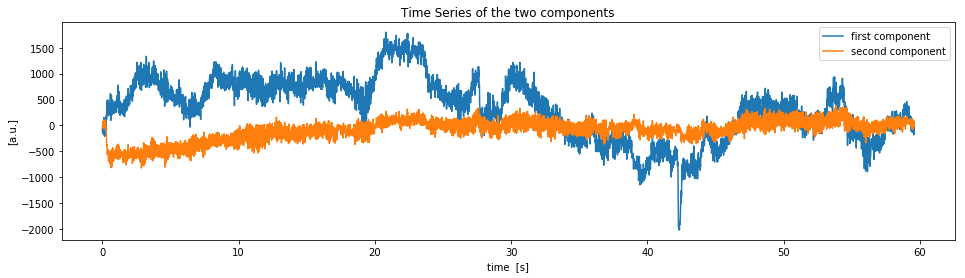

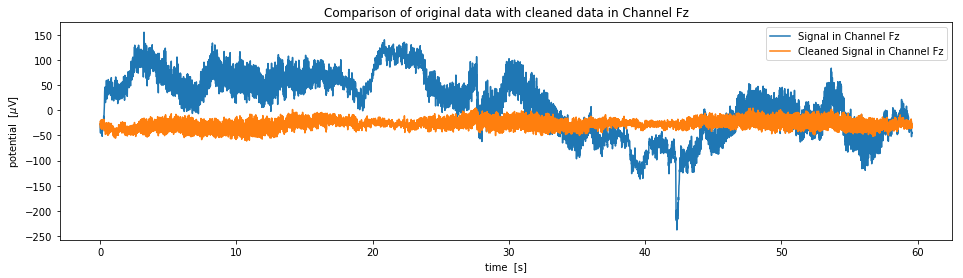

In [3]:
C= np.cov(cnt)
d, V = np.linalg.eigh(C)

idx=[-1,-2]
W = V[:,idx]
assert W.shape == (cnt.shape[0],len(idx)),'error in filter matrix'
cnt_sources = W.T@cnt # backward model

A = W
artifact_partof_cnt = A@cnt_sources # forward model
assert artifact_partof_cnt.shape == cnt.shape, 'error in artifact eeg'

cnt_artifree=cnt-artifact_partof_cnt

timeaxis = np.arange(0, np.shape(cnt)[1]/fs, 1/fs)

plt.figure(figsize=(16,4))
plt.plot(timeaxis, cnt_sources[0,:], label= 'first component')
plt.plot(timeaxis, cnt_sources[1,:], label= 'second component')

plt.xlabel('time  [s]')
plt.ylabel('[a.u.]')
plt.legend()
plt.title('Time Series of the two components')

ci = clab.index('Fz')
plt.figure(figsize=(16,4))
plt.plot(timeaxis, cnt[ci, :], label='Signal in Channel {}'.format(clab[ci]))
plt.plot(timeaxis, cnt_artifree[ci, :], label='Cleaned Signal in Channel {}'.format(clab[ci]))

plt.xlabel('time  [s]')
plt.ylabel('potential  [$\mu$V]')
plt.legend()
plt.title('Comparison of original data with cleaned data in Channel {}'.format(clab[ci]))

## Exercise 2: PCA on band-pass filtered data (4 points)
Design a butterworth band-pass filter of order 10 with the frequency band 8-12 Hz (function `sp.signal.butter`). Apply that band-pass filter to the original EEG signals (function `sp.signal.lfilter`) and compare raw and filtered signals for channel Oz.
Visualize the covariance matrix (functions np.cov and pl.imshow) of the filtered data and check the eigenvalue spectrum, to determine how many strong principal components there are. Visualize those principal components ins the same way as in Ex. \#01 sheet \#05. Compare the results and discuss shortly.

(118, 5958)


Text(0.5,1,'Projection Vector of Third Component')

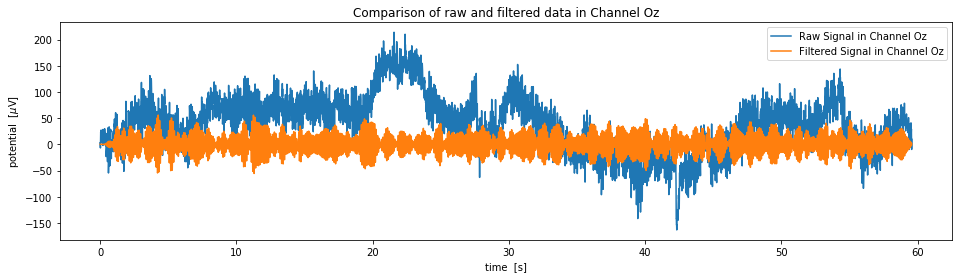

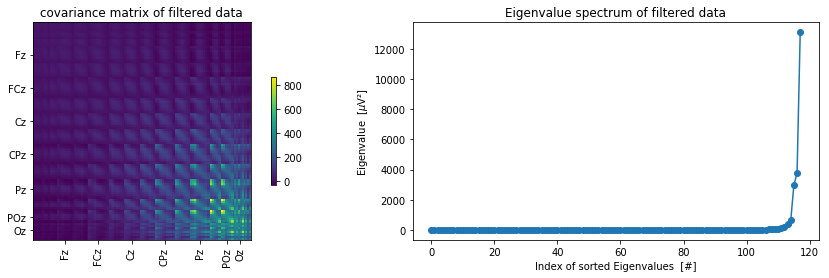

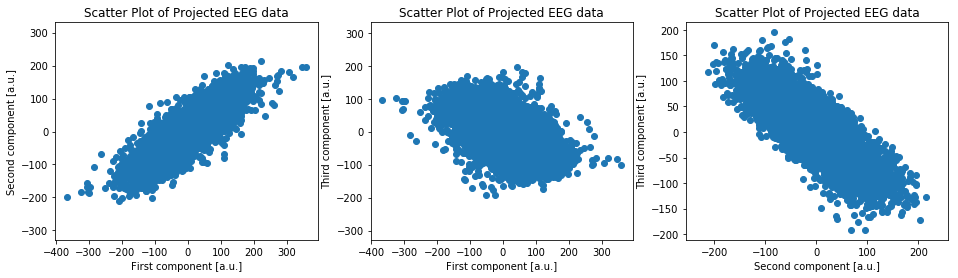

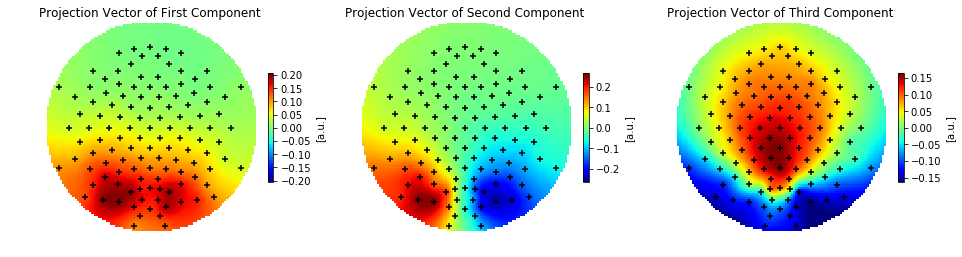

In [4]:
band=[8 ,12]
b,a = scipy.signal.butter(10,(band[0]/fs*2,band[1]/fs*2), btype = 'bandpass')
cnt_filtered = scipy.signal.lfilter(b,a,cnt)
print(cnt_filtered.shape)

ci = clab.index('Oz')
plt.figure(figsize=(16,4))
plt.plot(timeaxis, cnt[ci, :], label='Raw Signal in Channel {}'.format(clab[ci]))
plt.plot(timeaxis, cnt_filtered[ci, :], label='Filtered Signal in Channel {}'.format(clab[ci]))

plt.xlabel('time  [s]')
plt.ylabel('potential  [$\mu$V]')
plt.legend()
plt.title('Comparison of raw and filtered data in Channel {}'.format(clab[ci]))

#Visualize the covariance matrix (functions np.cov and pl.imshow) 
#of the filtered data and check the eigenvalue spectrum, to determine how many strong principal components there are.
C_filtered = np.cov(cnt_filtered)
d_filtered, V_filtered= np.linalg.eigh(C_filtered)  

# some channels chosen
selected_channels = ['Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'POz', 'Oz']
idx = [clab.index(x) for x in selected_channels]

plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
plt.imshow(C_filtered)
plt.title('covariance matrix of filtered data')
plt.colorbar(shrink=.5)
plt.xticks(idx, selected_channels, rotation='vertical')
plt.yticks(idx, selected_channels)

plt.subplot(1, 2, 2)
plt.plot(d_filtered, '-o' )
plt.title('Eigenvalue spectrum of filtered data')
plt.xlabel('Index of sorted Eigenvalues  [#]')
plt.ylabel('Eigenvalue  [$\mu$V²]')

##Visualize those principal components ins the same way as in Ex. #01 sheet #05
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.scatter(cnt_filtered.T.dot(V[:,-1]),cnt_filtered.T.dot(V[:,-2]))
plt.title('Scatter Plot of Projected EEG data')
plt.axis('equal')
plt.xlabel('First component [a.u.]')
plt.ylabel('Second component [a.u.]')

plt.subplot(1,3,2)
plt.scatter(cnt_filtered.T.dot(V[:,-1]),cnt_filtered.T.dot(V[:,-3]))
plt.title('Scatter Plot of Projected EEG data')
plt.axis('equal')
plt.xlabel('First component [a.u.]')
plt.ylabel('Third component [a.u.]')

plt.subplot(1,3,3)
plt.scatter(cnt_filtered.T.dot(V[:,-2]),cnt_filtered.T.dot(V[:,-3]))
plt.title('Scatter Plot of Projected EEG data')
plt.axis('equal')
plt.xlabel('Second component [a.u.]')
plt.ylabel('Third component [a.u.]')

plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
bci.scalpmap(mnt, V_filtered[:,-1], clim='sym', cb_label='[a.u.]')
plt.title('Projection Vector of First Component')

plt.subplot(1,3,2)
bci.scalpmap(mnt, V_filtered[:,-2], clim='sym', cb_label='[a.u.]')
plt.title('Projection Vector of Second Component')

plt.subplot(1,3,3)
bci.scalpmap(mnt, V_filtered[:,-3], clim='sym', cb_label='[a.u.]')
plt.title('Projection Vector of Third Component')

In [5]:
# It seems there are 3 strong components (last 3) 
# after filtering the first two strongest components are positively correlated, 
# 1st and 3rd hard to tell and 
# 2nd and 3rd are negatively correlated

## Exercise 3: Reconstruction with few PCs  (3 points)
Calculate the signals corresponding to the strongest principal components (second part of Ex. \#02) of the filtered data (project EEG data onto the PCs, i.e. go from *sensor space* to *source space*). Then reconstruct the EEG data from those strong principal components, i.e. project the signals obtained in the first step back into *sensor space*. Compare the band-pass filtered signal with the reconstructed signal in channel Oz. For plotting, the first six seconds are enough. You can also apply an error measure of your choice.

(118, 3)
(3, 5958)
(118, 5958)


Text(0.5,1,'Error measure of Signal in Channel Oz')

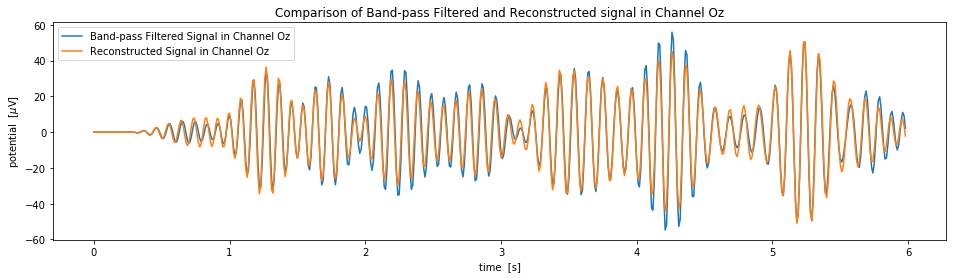

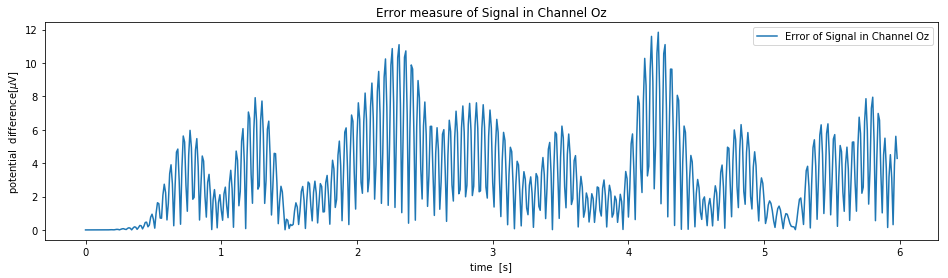

In [6]:
idx=[-1,-2,-3]
W_filtered= V_filtered[:,idx]
assert W_filtered.shape == (cnt_filtered.shape[0],len(idx)),'error in filter matrix'
cnt_filtered_sources = W_filtered.T@cnt_filtered # backward model
print(W_filtered.shape)
print(cnt_filtered_sources.shape)

A_filtered = W_filtered
reconstr_cnt = A_filtered@cnt_filtered_sources # forward model
assert reconstr_cnt.shape == cnt_filtered.shape, 'error in artifact eeg'
print(reconstr_cnt.shape)

ci = clab.index('Oz')
nSec = 6
timeidx= np.arange(0, nSec*fs-1)

#### TO-DO
error = np.abs(cnt_filtered[ci, timeidx] - reconstr_cnt[ci, timeidx])

####
plt.figure(figsize=(16,4))
plt.plot(timeaxis[timeidx], cnt_filtered[ci, timeidx], label='Band-pass Filtered Signal in Channel {}'.format(clab[ci]))
plt.plot(timeaxis[timeidx], reconstr_cnt[ci, timeidx], label='Reconstructed Signal in Channel {}'.format(clab[ci]))

plt.xlabel('time  [s]')
plt.ylabel('potential  [$\mu$V]')
plt.legend()
plt.title('Comparison of Band-pass Filtered and Reconstructed signal in Channel {}'.format(clab[ci]))

plt.figure(figsize=(16,4))
plt.plot(timeaxis[timeidx], error, label='Error of Signal in Channel {}'.format(clab[ci]))
plt.xlabel('time  [s]')
plt.ylabel('potential  difference[$\mu$V]')
plt.legend()
plt.title('Error measure of Signal in Channel {}'.format(clab[ci]))

## Exercise 4: Artifact to signal ratio in bandpass-filtered signal  (4 points)
For this task we again assume that the two components from Ex. \#01 sheet \#05 reflect eye movements, while all other components do not contain artifacts from eye movement.

Determine for each channel which proportion of the overall variance caused by these eye movements is left after bandpass-filtering and plot this information as a scalp map. Also, calculate the Signal-To-Noise ratio (SNR) per channel in Decibel (dB).

*Hint: The PCA for these components was done on the unfiltered signal, while the filtered signal has a different covariance matrix.*

Text(0.5,1,'Signal-To-Noise ratio (SNR) per channel in Decibel (dB).')

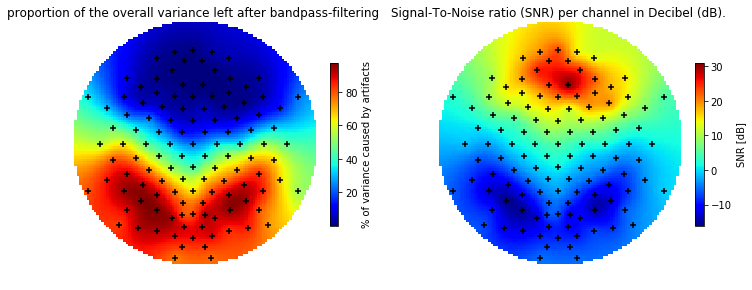

In [7]:
D=np.diag(d_filtered)
var_rest =np.diag(V_filtered[:,:-2]@D[:-2,:-2]@V_filtered[:,:-2].T)
var_eyes =np.diag(V_filtered[:,-2:]@D[-2:,-2:]@V_filtered[:,-2:].T)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
ratio = 100 * var_eyes / np.diag(C_filtered)
bci.scalpmap(mnt, ratio, cb_label='% of variance caused by artifacts')
plt.title('proportion of the overall variance left after bandpass-filtering')

plt.subplot(1,2,2)
ratio = 10 * np.log10(var_rest/var_eyes)
bci.scalpmap(mnt, ratio, cb_label='SNR [dB]')
plt.title('Signal-To-Noise ratio (SNR) per channel in Decibel (dB)')